# Air quality prediction service

Baseado na API do site: https://aqicn.org/, é possível obter o Indíce de Qualidade do Ar (AQI) de diversas cidades no mundo, de modo que com o aumento do índice, maior o risco pra população. Entre as cidades listadas, consta a cidade de Santos - SP. 
Santos é uma cidade que atrai muitos turistas, principalmente no verão, por ser uma cidade litorânea, ademais apresenta um índice de qualidade do ar, eventualmente, no nível Moderado, no qual indica um leve risco para pessoas mais sensíveis a poluição do ar.

Desse modo, este projeto visa a implementação de um projeto completo de Machine Learning, visando a previsão da qualidade do ar da cidade de Santos para os próximos dias. As etapas do projeto serão divididas como a seguir:

- Coleta dos dados históricos 
- Preparação dos Dados para o modelo
- Treinamento do Modelo
- Coleta do AQI em tempo real via API 
- Deploy do Modelo via Streamlit

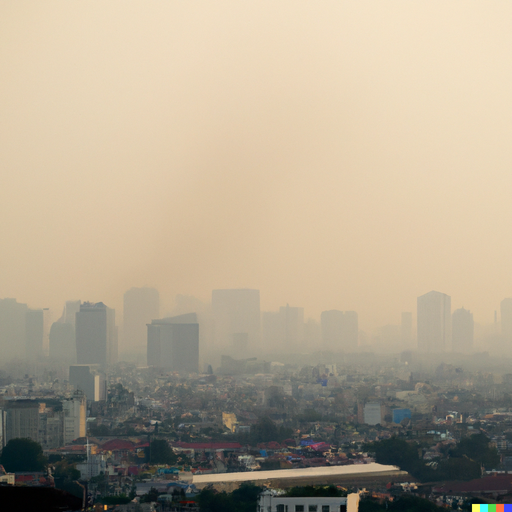

In [1]:
from IPython import display
display.Image("air-polution.png")


## Coleta dos Dados históricos

A coleta dos dados históricos pode ser obtida pelo Data Platform do site: https://aqicn.org/data-platform/register/

Nesta etapa também será realizado a importação das bibliotecas utilizadas no projeto, além da coleta dos Dados da cidade de Santos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import pmdarima as pm
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

C:\Users\ygorf\AppData\Local\Temp\ipykernel_13732\1586935810.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
start_date = '2014-01-01'
end_date = '2023-01-01'
idx = pd.date_range(start=start_date, end=end_date, freq='D')
df_data = pd.DataFrame({'datetime': idx})
df_data

,datetime
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
3283,2022-12-28
3284,2022-12-29
3285,2022-12-30
3286,2022-12-31


In [13]:
df = pd.read_csv('congonhas.csv')
pd.to_datetime(df["date"])
df.sort_values(by = 'date',inplace=True,ascending=True)
df.set_index('date',inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') 
df

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2014/1/1,NaN,18.0,NaN,8.0,NaN,NaN
2014/1/10,67.0,33.0,NaN,26.0,1.0,8.0
2014/1/11,76.0,30.0,NaN,27.0,1.0,9.0
2014/1/12,72.0,28.0,NaN,22.0,1.0,7.0
2014/1/13,64.0,30.0,NaN,27.0,1.0,9.0
...,...,...,...,...,...,...
2023/2/5,25.0,10.0,NaN,15.0,NaN,5.0
2023/2/6,28.0,16.0,NaN,28.0,NaN,7.0
2023/2/7,49.0,18.0,NaN,30.0,NaN,7.0


In [8]:
df = pd.read_csv('ibirapuera.csv')
pd.to_datetime(df["date"])
df.sort_values(by = 'date',inplace=True,ascending=True)
df.set_index('date',inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') 
df

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2014/1/1,NaN,NaN,NaN,4.0,NaN,5.0
2014/1/10,NaN,31.0,53.0,18.0,NaN,8.0
2014/1/11,NaN,27.0,48.0,15.0,NaN,8.0
2014/1/12,NaN,28.0,56.0,10.0,NaN,7.0
2014/1/13,NaN,25.0,27.0,17.0,NaN,9.0
...,...,...,...,...,...,...
2023/2/5,22.0,NaN,26.0,4.0,NaN,1.0
2023/2/6,28.0,NaN,22.0,10.0,NaN,1.0
2023/2/7,33.0,NaN,31.0,11.0,NaN,2.0


In [14]:
df[' pm25'].count()

3138

In [11]:
df = pd.read_csv('tietê.csv')
pd.to_datetime(df["date"])
df.sort_values(by = 'date',inplace=True,ascending=True)
df.set_index('date',inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') 
df

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2014/1/1,NaN,19.0,NaN,NaN,NaN,5.0
2014/1/10,74.0,39.0,NaN,42.0,2.0,10.0
2014/1/11,90.0,39.0,NaN,32.0,1.0,11.0
2014/1/12,89.0,19.0,NaN,21.0,NaN,10.0
2014/1/13,61.0,33.0,NaN,33.0,1.0,11.0
...,...,...,...,...,...,...
2023/2/5,32.0,13.0,NaN,13.0,NaN,NaN
2023/2/6,33.0,25.0,NaN,25.0,1.0,8.0
2023/2/7,62.0,24.0,NaN,25.0,NaN,7.0


In [12]:
df = pd.read_csv('santos.csv')
pd.to_datetime(df["date"])
df.sort_values(by = 'date',inplace=True,ascending=True)
#df.set_index('date',inplace=True)
df

,date,pm25,pm10,o3,no2,so2,co
3268,2014/1/1,,34,13,6,5,
3150,2014/1/10,50,34,15,11,5,
3151,2014/1/11,64,38,21,12,7,
3152,2014/1/12,67,22,15,8,2,
3153,2014/1/13,50,27,13,13,3,
...,...,...,...,...,...,...,...
1,2023/2/5,29,18,21,12,1,
2,2023/2/6,36,29,16,22,1,
3,2023/2/7,54,22,24,13,2,
4,2023/2/8,39,20,23,14,2,


- pm25: Partículas finas com diâmetro de 2,5 mícrons ou menor, inalável ​​para os pulmões e podem induzir efeitos adversos à saúde. 
- pm10: Partículas com diâmetro de 10 mícrons, inalável ​​para os pulmões e podem induzir efeitos adversos à saúde.
- o3: Ozone scale. 
- no2: Nitrogen Dioxide scale.
- so2: Sulphur dioxide scale. 

In [14]:
df.groupby(df. date.dt.year)[' pm25'].count()

AttributeError: Can only use .dt accessor with datetimelike values

## Preparação dos Dados para o modelo

Utilizando o método built-in info(), pode-se observar o tipo de cada coluna do Dataframe e valores não nulos. Verificando o dataset percebe-se a ocorrência de valores nulos os quais não foram apresentados com o metodo info(), isso ocorre devido aos tipos observados nas colunas serem object e, para verificação dos valores nulos, as colunas devem ser do tipo numéricas (como int ou float).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 2014/1/1 to 2023/2/9
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0    pm25   3289 non-null   object
 1    pm10   3289 non-null   object
 2    o3     3289 non-null   object
 3    no2    3289 non-null   object
 4    so2    3289 non-null   object
 5    co     3289 non-null   object
dtypes: object(6)
memory usage: 179.9+ KB


In [16]:
#Usar df.astype('float') diretamente ocasionou em erro devido aos null-values
df = df.apply(pd.to_numeric, errors='coerce') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 2014/1/1 to 2023/2/9
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    pm25   3232 non-null   float64
 1    pm10   3229 non-null   float64
 2    o3     3132 non-null   float64
 3    no2    3163 non-null   float64
 4    so2    2540 non-null   float64
 5    co     7 non-null      float64
dtypes: float64(6)
memory usage: 179.9+ KB


- A coluna "co" apresenta apenas 7 valores, desse modo, não irá interferir na predição, podendo dropar a coluna.
- A coluna "so2 apresenta valores nulos significativos.
- As outras apresentam uma faixa de 3% dos valores nulos, esperamos que isso não afete significativamente o modelo.
Visando preencher os valores nulos do Dataset, foi utilizado o método Interpolate() 


In [6]:
df.drop(df.columns[5],axis = 1,inplace=True)
df.drop(index='2014/1/1',inplace=True)
df.interpolate(inplace=True)
df.head(20)

,pm25,pm10,o3,no2,so2
date,,,,,
2014/1/10,50.0,34.0,15.000000,11.000000,5.00
2014/1/11,64.0,38.0,21.000000,12.000000,7.00
2014/1/12,67.0,22.0,15.000000,8.000000,2.00
2014/1/13,50.0,27.0,13.000000,13.000000,3.00
2014/1/14,50.0,41.0,30.000000,14.000000,10.00
2014/1/15,70.0,29.0,27.000000,15.000000,6.00
2014/1/16,61.0,28.0,13.000000,14.000000,7.00
2014/1/17,59.0,30.0,17.000000,13.000000,8.00
2014/1/18,59.0,26.0,11.000000,9.000000,5.00


In [20]:
df = pd.read_csv('SP202102.csv')
# pd.to_datetime(df["date"])
# df.sort_values(by = 'date',inplace=True,ascending=True)
# df.set_index('date',inplace=True)
df

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 74: invalid continuation byte

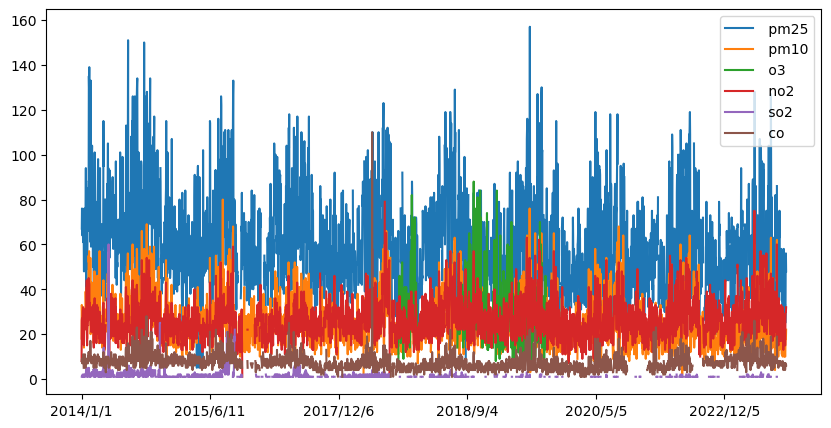

In [19]:
plt.figure(figsize=(10,5))
for column in df.columns:
    plt.plot(df[column], label=column)
plt.xticks(np.arange(0, len(df.index), 600))
plt.legend()
plt.show()

Cada tipo de partícula de ar (pm25, o3, no2,...) possui um indíce de qualidade específico. O site apresenta o índice pm25 ou pm10, definido pelo qual estiver maior no momento da coleta para cada cidade. É possível verificar na foto acima que o pm25 na cidade de Santos é frequentemente maior que o pm10, ou seja, esse valor é sempre o considerado, de uma maneira geral, para indicar a qualidade do ar. Portanto, o modelo de machine learning será aplicado ao pm25. 

## Treinamento do Modelo

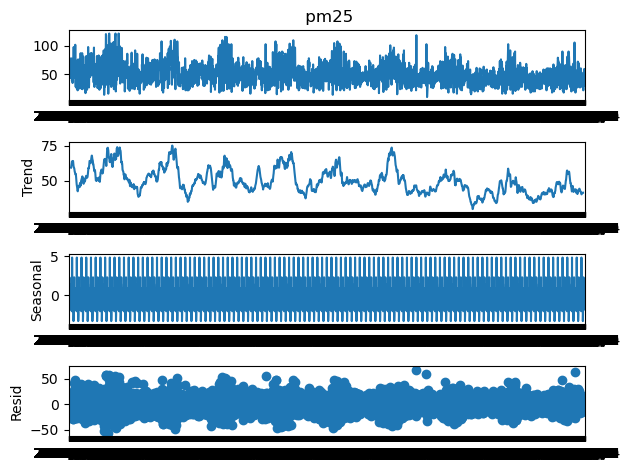

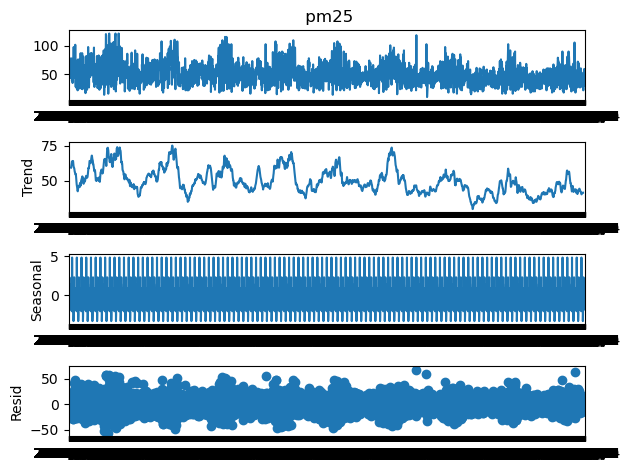

In [8]:
decompose = seasonal_decompose(df[" pm25"],period=30)
decompose.plot()